#### Kaggle Dataset

https://www.kaggle.com/datasets/sergylog/ab-test-data

# A/B test data

Experiment user data with two groups and revenue column

## About Dataset
The site launched an A/B test in order to increase income. The excel file contains raw data on the results of the experiment (userid), sample type (variantname) and income brought by the user (revenue).

The task is to analyze the results of the experiment and write your recommendations.

In [61]:
# data
import pandas as pd
import numpy as np

# statistics
from scipy import stats
from scipy.stats import norm

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('AB_Test_Results.csv')

In [3]:
data.dtypes

USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object

In [4]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [5]:
data = data.rename(columns = {'USER_ID':'id', 'VARIANT_NAME':'variant', 'REVENUE':'revenue'})

In [6]:
data.head()

,id,variant,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [7]:
data.describe()

,id,revenue
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [8]:
data.variant.value_counts()

variant    5016
control    4984
Name: variant, dtype: int64

### Groups:
variant = Treatment/Test group

control = Control group

## Users in both groups
So let's find out if we have users, which appeared in both groups. If we do, we'll drop them, because they will effect on experiment.

In [9]:
num_of_groups = data.groupby('id') \
                    .agg({'variant':'nunique'}) \
                    .value_counts()
num_of_groups

variant
1          4783
2          1541
dtype: int64

In [10]:
num_of_groups / num_of_groups.sum()

variant
1          0.756325
2          0.243675
dtype: float64

So over 24% of users are in both groups. Let's drop them

In [11]:
# first, let's see which users have 1 ab test group and then take only these users
single_variant_users = data \
                        .groupby('id', as_index = False) \
                        .agg({'variant':'nunique'}) \
                        .query('variant == 1') \
                        .id

In [12]:
# leave only records with users with the 1st ab test group
data = data[data.id.isin(single_variant_users)]

# check that the number of users matches what it was before the exception
data.groupby('id')['variant'].nunique().value_counts().iloc[0] == num_of_groups.iloc[0]

True

Let's see a distribution of the data:

<AxesSubplot:xlabel='variant', ylabel='revenue'>

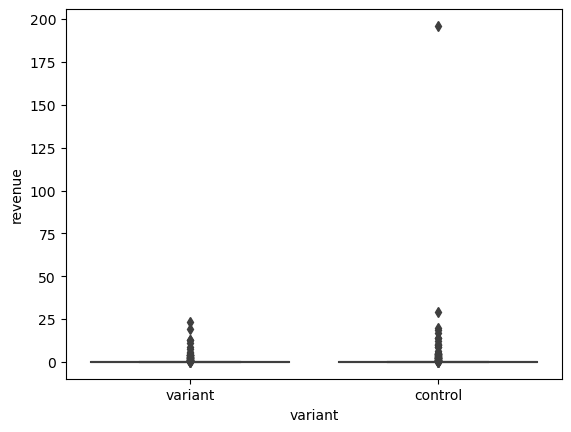

In [13]:
sns.boxplot(data = data, x = 'variant', y = 'revenue')

So there is one outlier, that we must find and delete it

In [14]:
data.sort_values(by = 'revenue', ascending = False)[:3]

# user with id = 3342 will be deleted from the records

,id,variant,revenue
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04


In [15]:
data = data[data.id != 3342]

([<matplotlib.axis.XTick at 0x1c0145905b0>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

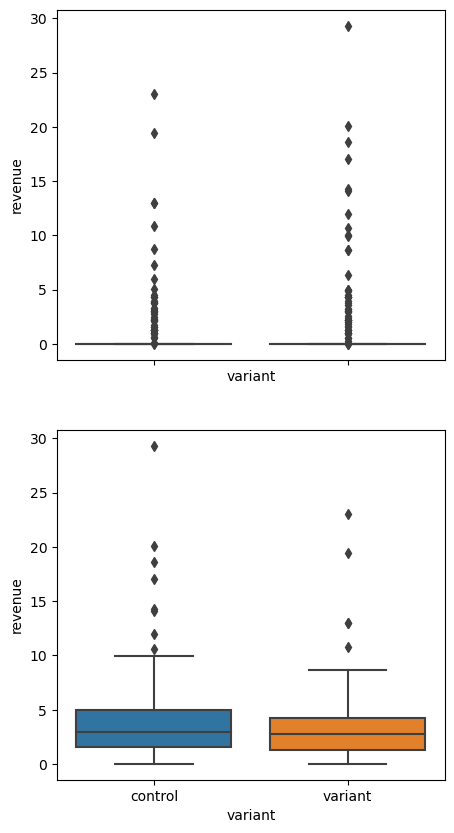

In [16]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,10))
sns.boxplot(ax = axes[0], data = data, x = 'variant', y = 'revenue')
sns.boxplot(ax = axes[1], data = data[data.revenue > 0], x = 'variant', y= 'revenue')
plt.xticks(np.arange(2), ('control', 'variant'))

We see that a lot of users have no purchases. Let's check if there are users which have multiple records (Example: they visited multiple times, but bought only once).

In [17]:
data[
    (data['revenue'] == 0) &
    data['id'].isin( data[data.revenue > 0]['id'] )
    ].shape[0]

52

52 users have multiple records, let's sum these records, to make single row for each user.

In [18]:
data = data \
        .groupby(['id','variant'], as_index = False) \
        .agg({'revenue':'sum'})

Let's look at the resulting distributions

([<matplotlib.axis.XTick at 0x1c0146904f0>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

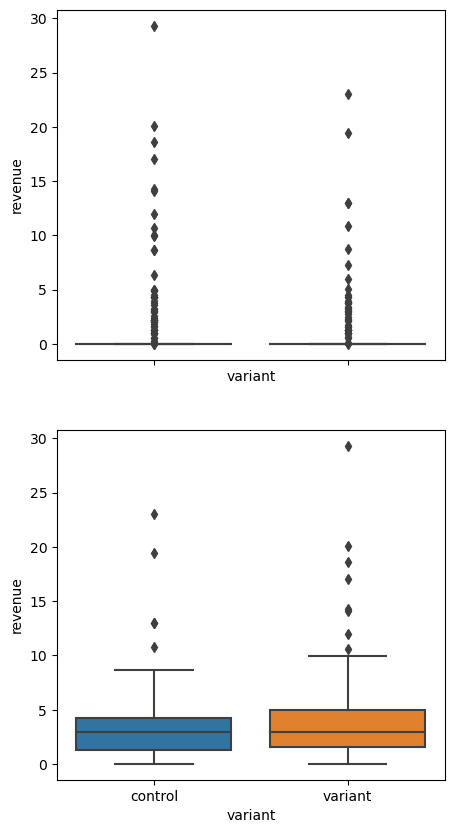

In [19]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,10))
sns.boxplot(ax = axes[0], data = data, x = 'variant', y = 'revenue')
sns.boxplot(ax = axes[1], data = data[data.revenue > 0], x = 'variant', y= 'revenue')
plt.xticks(np.arange(2), ('control', 'variant'))

Quartiles has changed.

Now it's time to look at statistics in the context of AB test groups for all users

In [20]:
# get metrics by groups
all_stats = data \
    .groupby(['variant'], as_index = False) \
    .agg({'id':'nunique', \
          'revenue': ['sum', 'mean', 'median', 'count']})

# create two additional metrics to see relative changes
orders_per_user = all_stats['revenue']['count'] / all_stats['id']['nunique']
revenue_per_user = all_stats['revenue']['sum'] / all_stats['id']['nunique']

# add them to the rest of the metrics in a separate group
all_stats.loc[:, ('per_user', 'orders')] = orders_per_user
all_stats.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stats

variant      id revenue                        per_user          
           nunique     sum      mean median count   orders   revenue
0  control    2389  274.55  0.114923    0.0  2389      1.0  0.114923
1  variant    2393  179.32  0.074935    0.0  2393      1.0  0.074935

We see that in the test group, the total amount of revenue and the average check per user decreased, but the number of orders per user slightly increased.

Let's also see how paying users behave.


In [21]:
paid_stats = data[data.revenue > 0] \
    .groupby(['variant'], as_index = False) \
    .agg({'id':'nunique', \
          'revenue': ['sum', 'mean', 'median', 'count']})

# create two additional metrics to see relative changes
orders_per_user = paid_stats['revenue']['count'] / paid_stats['id']['nunique']
revenue_per_user = paid_stats['revenue']['sum'] / paid_stats['id']['nunique']

# add them to the rest of the metrics in a separate group
paid_stats.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stats.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stats

variant      id revenue                        per_user          
           nunique     sum      mean median count   orders   revenue
0  control      53  274.55  5.180189   2.99    53      1.0  5.180189
1  variant      42  179.32  4.269524   2.97    42      1.0  4.269524

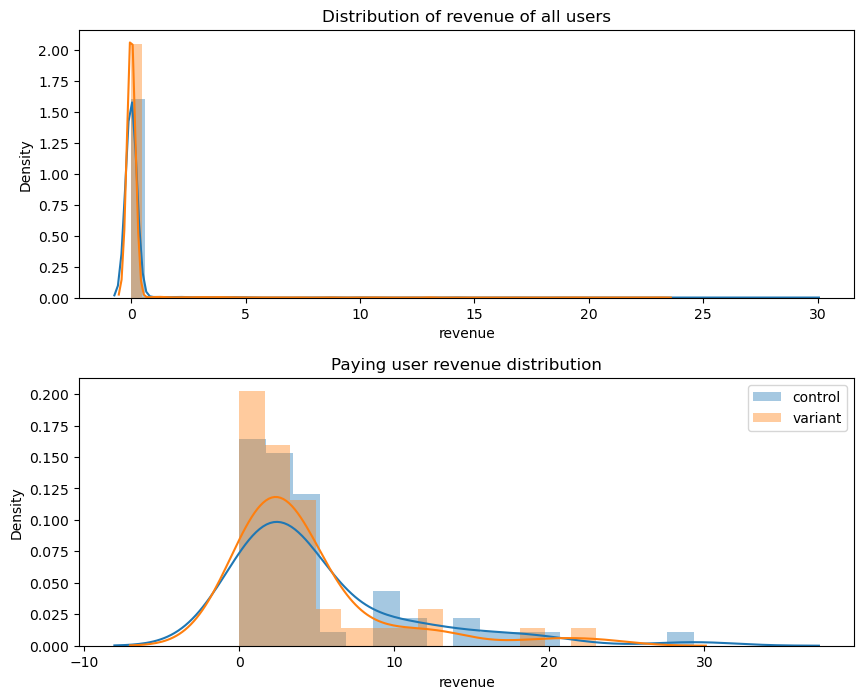

In [22]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(data.loc[data['variant'] == 'control', 'revenue'], ax = axes[0], label='control')
sns.distplot(data.loc[data['variant'] == 'variant', 'revenue'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(data.loc[(data['variant'] == 'control') & (data['revenue'] > 0), 'revenue'], ax = axes[1], label='control' )
sns.distplot(data.loc[(data['variant'] == 'variant') & (data['revenue'] > 0), 'revenue'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

Right tail

# Statistical analysis

## t-test

Since revenue distributed not normally, let's try to logarithm this column. To avoid "log(0) = inf" we will add a constant C = 1

In [23]:
data_log = data.copy()

In [24]:
data_log.revenue += 1

In [25]:
data_log['log_revenue'] = np.log(data_log.revenue)

<AxesSubplot:xlabel='log_revenue', ylabel='Count'>

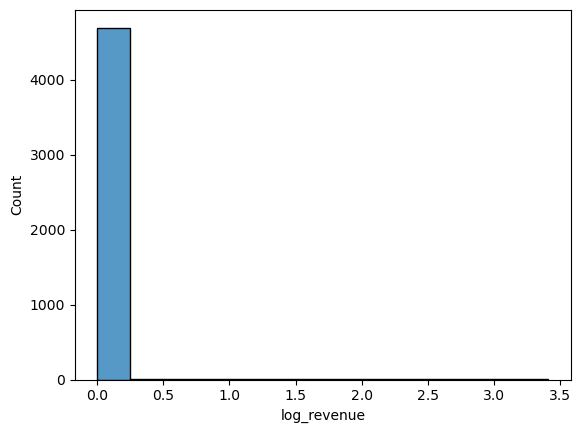

In [26]:
sns.histplot(data_log.log_revenue)

Nothing changed, but let's check homoscedasticity of variances and try normal test.

#### homoscedasticity - Levene

In [27]:
stats.levene(data_log[data_log.variant == 'variant'].log_revenue, \
             data_log[data_log.variant == 'control'].log_revenue)

# logarithmed data test

LeveneResult(statistic=1.801920795937881, pvalue=0.17954420195095716)

In [28]:
stats.levene(data[data.variant == 'variant'].revenue, \
             data[data.variant == 'control'].revenue)

# default data test

LeveneResult(statistic=1.8315496300786236, pvalue=0.17600861562570844)

Pvalue = 0.18 , that means there is no statistical difference between groups variances.

\* Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

#### normal test

In [29]:
stats.shapiro(data_log.log_revenue)

ShapiroResult(statistic=0.10447388887405396, pvalue=0.0)

In [30]:
stats.normaltest(data_log.log_revenue)

NormaltestResult(statistic=7084.042917001436, pvalue=0.0)

Distribution isnt normal, but it doesnt affect to t-test (https://koch-kir.medium.com/история-одного-обмана-или-требования-к-распределению-в-статистических-тестах-55139a5558d)

#### t-test

In [31]:
stats.ttest_ind(data[data.variant == 'variant'].revenue, \
                data[data.variant == 'control'].revenue)


Ttest_indResult(statistic=-1.353347564404142, pvalue=0.1760086156257086)

Pvalue = 0.18

According to t-test - there is no statistical difference between Control and Variant groups.

And those who pay:

In [32]:
stats.ttest_ind(data[(data.variant == 'variant') & (data.revenue > 0)].revenue, \
                data[(data.variant == 'control') & (data.revenue > 0)].revenue)


Ttest_indResult(statistic=-0.7968567151823726, pvalue=0.42756390222211027)

Pvalue = 0.43

According to t-test - there is no statistical difference between Control and Variant groups who pay.

## U-test

In [33]:
stats.mannwhitneyu(data[data.variant == 'variant'].revenue, \
                   data[data.variant == 'control'].revenue)


MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

Pvalue = 0.18

According to U-test - there is no statistical difference between Control and Variant groups.

And those who pay:

In [34]:
stats.mannwhitneyu(data[(data.variant == 'variant') & (data.revenue > 0)].revenue, \
                data[(data.variant == 'control') & (data.revenue > 0)].revenue)


MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

Pvalue = 0.53

According to U-test - there is no statistical difference between Control and Variant groups who pay.

## Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [35]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


Let's generate samples for all users

In [36]:
control = get_bootstrap_samples(data.loc[data.variant == 'control', 'revenue'].values, 10000)
variant = get_bootstrap_samples(data.loc[data.variant == 'variant', 'revenue'].values, 10000)

And for those who pay

In [37]:
control_paid = get_bootstrap_samples(data.loc[(data.variant == 'control') & (data.revenue > 0), 'revenue'].values, 10000)
variant_paid = get_bootstrap_samples(data.loc[(data.variant == 'variant') & (data.revenue > 0), 'revenue'].values, 10000)

Let's look at the distribution of means in the ab test groups

Text(0.5, 1.0, 'Sample mean distribution for all users')

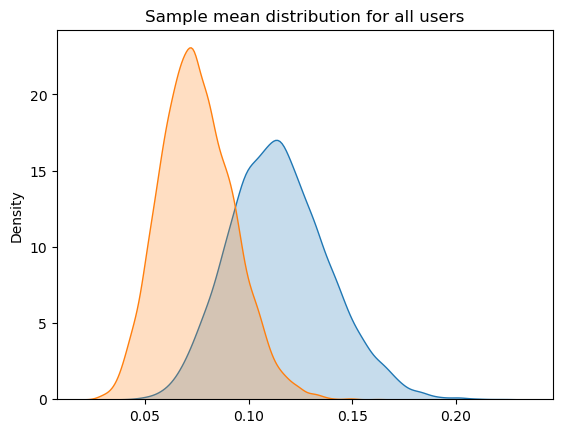

In [38]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

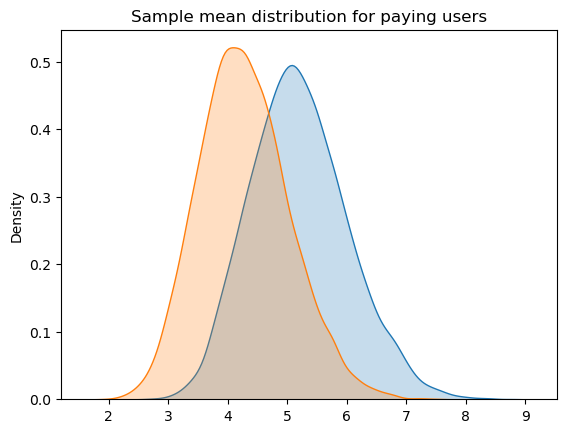

In [39]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

In [40]:
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [62]:
def get_bootstrap(
    data_column_1, # col1
    data_column_2, # col2
    boot_it = 1000, # size of bootstrap sub-samples
    statistic = np.mean, # statistics - mean
    bootstrap_conf_level = 0.95 # confidence level
):
    boot_data = []
    for i in tqdm(range(boot_it)): # extract sub-samples
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # parameter of returning
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean()
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualisation
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

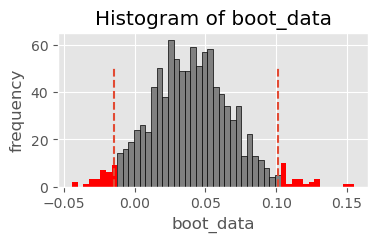

In [63]:
plt.figure(figsize = (4,2))
booted_data = get_bootstrap(data.loc[data.variant == 'control', 'revenue'],
              data.loc[data.variant == 'variant', 'revenue'])

In [64]:
booted_data["p_value"] # alpha

0.17025783254391602

In [65]:
booted_data["quants"] # Confidence Interval

,0
0.025,-0.014720
0.975,0.101377


Pvalue = 0.17

According to Bootstrap test - there is no statistical difference between Control and Variant groups who pay.

# Conclusions
Before statistical tests we have filtered the data: dropped users which were in both groups, User_id=3342 was excluded (outlier), summarised multiple records for each user into one, toke a look to statistics of all users and paid users.

According to stats of users variant group has lower revenue that control group, but there is no statistical difference between two groups in all stats tests.